# Identificador Natureza Morta x Paisagem

## Autor
Nome: Kess Jhones Gomes Tavares  
Matrícula: 180124498  
Github: [KessJhones](https://github.com/kessJhones) 
## Objetivo
O objetivo deste artigo é criar um modelo capaz de diferenciar pinturas de dois tipos:

### Natureza Morta
A natureza morta é categoria artística que possui objetos inanimados como temática central, normalmente dispostos sob uma mesa incluindo utensílios e alimentos organizados pelo artista de maneira única.

### Paisagem
A pintura de paisagem é um termo utilizado para a arte que representa cenas da natureza, como montanhas, vales, rios, árvores e florestas. É utilizado especialmente para representar a arte onde o tema principal é uma visão ampla, com seus elementos dispostos em uma composição coerente. Quase sempre se inclui a vista do céu, o tempo usualmente é um elemento da composição.

In [ ]:
# O comando pip install é utilizado para instalar pacotes do python
# Iremos usar o comando pip install -Uqq fastai para instalar a biblioteca do fastai, usado para cria, modelar e aplicacar o sistema de predição
# Também iremos instalar o duckduckgo_search para encontrar as URLS de imagens.

%pip install -Uqq fastai
%pip install duckduckgo_search

# Obtendo imagens
Utilizamos o ddg_images para buscar os links das imagens que serão utilizadas.

In [ ]:
from duckduckgo_search import ddg_images
from fastcore.all import *

def search_images(term: str, max_images=30):
    print(f"Searching for '{term}'")
    return L(ddg_images(term, max_results=max_images)).itemgot('image')

Utilizamos a fastdownload para realizar o download de imagens a partir do link.
Aqui temos primeiro uma imagem representando uma Paisagem e em seguida um representando uma Natureza Morta.


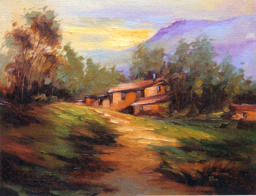

In [ ]:
from fastdownload import download_url
from fastai.vision.all import *
url = 'https://www.al.sp.gov.br/repositorio/noticia/03-2009/kELVAobra.jpg'
dest = 'paisagem.jpg'
download_url(url, dest, show_progress=False)
Image.open('paisagem.jpg').to_thumb(256,256)

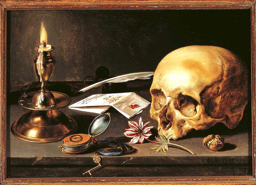

In [ ]:
url = 'https://upload.wikimedia.org/wikipedia/commons/thumb/e/e8/Pieter_Claeszoon-_Vanitas_-_Still_Life_%281625%2C_29%2C5_x_34%2C5_cm%29.JPG/800px-Pieter_Claeszoon-_Vanitas_-_Still_Life_%281625%2C_29%2C5_x_34%2C5_cm%29.JPG'
dest = 'naturezaMorta.jpg'
download_url(url, dest, show_progress=False)
Image.open('naturezaMorta.jpg').to_thumb(256,256)

Pesquisamos e baixamos dois grupos de imagens: __'Pintura Natureza Morta' e 'Pintura Paisagem'__

In [ ]:
searches = 'pintura natureza morta','pintura paisagem'
path = Path('paintings')
from time import sleep

for o in searches:
    dest = (path/o)
    dest.mkdir(exist_ok=True, parents=True)
    download_images(dest, urls=search_images(f'{o}'))
    sleep(10)
    resize_images(path/o, max_size=600, dest=path/o)

Searching for 'pintura natureza morta'
Searching for 'pintura paisagem'


Aqui verificamos se as imagens foram baixadas corretamente, as que apresentarem problemas são excluídas.

In [ ]:
failed = verify_images(get_image_files(path))
failed.map(Path.unlink)
len(failed)

0

Para criar nosso modelo para fazer a predição são necessários os `DataLoaders`, que é um objeto que contém um conjunto de treinamento __(imagens usadas para criar um modelo)__ e um conjunto de validação __(imagens usadas para verificar a precisão do modelo)__

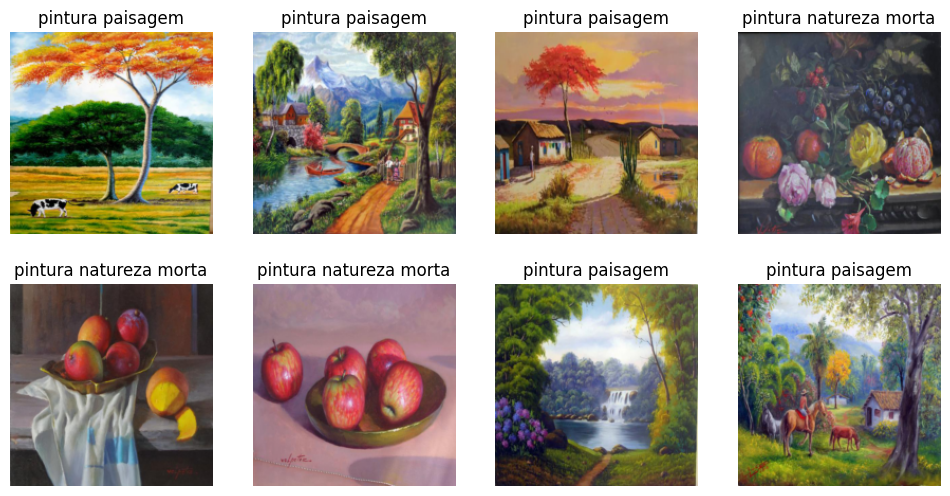

In [ ]:
dls = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=[Resize(192, method='squish')]
).dataloaders(path, bs=32, pin_memory=False)

dls.show_batch(max_n=8)

O DataBlock tem esses parâmetros:

`blocks`: Os nossos inputs são imagens, por isso estamos usando ImageBlocks, e nossos outputs são categorias, no nosso caso (Paisagem e Natureza Morta).

`get-items`: Para encontrar todos os nossos inputs, usamos a função get_image_files.

`splitter`: Aqui estamos dividindo os dados para o treinamento e validação. No nosso caso, 20% dos dados vão ser usados para validação e não serão usados no treinamento.

`get_y`: Isso irá associar cada imagem com o rótulo da pasta em que se encontra, por isso o nome das pastas em que as imagens se encontram devem ser significativos.

`item_tfms`: Isso irá redimensionar as imagens para 192px, utilizando o método de 'squish'

# Treinando o modelo
Abaixo treinaremos o modelo utilizando a função 'vision_learner', na qual a 'restnet50' é a rede neural convolucional utilizada. Logo após utilizamos o 'fine_tune', que utiliza modelos pré-treinados para melhorar o modelo já criado.


In [ ]:
learn = vision_learner(dls, resnet50, metrics=error_rate)
learn.fine_tune(10)

epoch,train_loss,valid_loss,error_rate,time
0,0.782026,0.707512,0.181818,00:21
1,0.604408,0.867804,0.181818,00:29
2,0.445791,1.032205,0.090909,00:22
3,0.331546,1.160243,0.090909,00:22
4,0.350642,1.479583,0.090909,00:21
5,0.289299,1.605666,0.090909,00:20
6,0.245508,1.625702,0.090909,00:21
7,0.212617,1.587041,0.090909,00:22
8,0.187066,1.525144,0.090909,00:21
9,0.182642,1.438804,0.090909,00:21


# Testando o modelo
Agora vamos utilizar as imagens pré-selecionadas para testar o nosso modelo.

Isso é: pintura paisagem.
Probabilidade de ser do tipo pintura paisagem: 99.99%


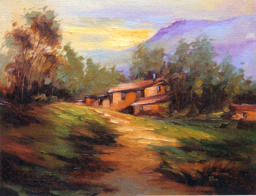

In [ ]:
is_good,_,probs = learn.predict(PILImage.create('paisagem.jpg'))
print(f"Isso é: {is_good}.")
print(f"Probabilidade de ser do tipo {is_good}: {probs.sort()[0][-1]*100:.2f}%")
Image.open('paisagem.jpg').to_thumb(256,256)

Isso é: pintura natureza morta.
Probabilidade de ser do tipo pintura natureza morta: 84.75%


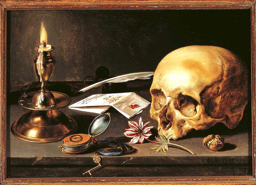

In [ ]:
is_good,_,probs = learn.predict(PILImage.create('naturezaMorta.jpg'))
print(f"Isso é: {is_good}.")
print(f"Probabilidade de ser do tipo {is_good}: {probs.sort()[0][-1]*100:.2f}%")
Image.open('naturezaMorta.jpg').to_thumb(256,256)

# Conclusão

Pinturas de Paisagens e de Natureza Mortas possuem características bem diferentes entre si, por isso conseguimos uma taxa de erro de 9.09%. Desta forma o modelo erra em poucas ocasiões.
Realizei um teste tentando criar um classificador de movimentos artísticos, que ficou com 30% de taxa de erro, já que os rótulos utilizados tinham bem mais características em comum.

 

# Referência Bibliográfica

Howard, Jeremy. Practical Deep Learning for Coders, Fast.ai, 2019. Disponível em: https://course.fast.ai/Lessons/lesson1.html. Acesso em: 04 abr. 2023.

Lopes, Manuela. Natureza morta: a arte que perdurou milênios. Arte Ref, 21 ago. 2019. Disponível em: https://arteref.com/pintura/natureza-morta-a-arte-que-perdurou-milenios/. Acesso em: 05 abr. 2023.

"Pintura de paisagem". In: Wikipédia, a enciclopédia livre. Wikimedia Foundation, 2023. Disponível em: https://pt.wikipedia.org/wiki/Pintura_de_paisagem. Acesso em: 05 abr. 2023.